# [TPV3] Tweaking the blending function
by JN Hayek (Created on 06.08.2020)


In [1]:
import os, sys, math, time

from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter, MaxNLocator


sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *
from Lib_GeneralSignalProcNAnalysis import *
from Lib_ProfilePlotting import *
from Lib_ProfileProcessing import *


#=================== Plotting style ===================
plt.style.use('science')

from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

#definition of colormap
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
from palettable.cartocolors.qualitative import Safe_5 as LineColor

cmap = ListedColormap(LineColor.mpl_colors[:])

In [2]:
plt.rcParams["figure.titlesize"] = 'large'

In [3]:

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
def FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# Timestamp variable
start_time = time.time()

In [5]:
# Save into a class the 
class TPV3reference:
    def __init__(self, filename, coordinates, RefSource="SEM2DPACK"):
        
        line = pd.read_csv(filename.format("slip"), header=None)
        self.Time = line[0]
        self.Slip = line[1]
        
        line = pd.read_csv(filename.format("sr"), header=None)
        self.SlipRate = line[1]
        
        self.Coord = coordinates #Only used for labels and 
        self.RefSource = RefSource
    #end __init__
    
    # Default object printing information
    def __repr__(self):
        return "The TPV3reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __repr__
    
    def __str__(self):
        return "The TPV3reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __str__
    
    def PlotReference(self, ax, SlipSlipRate, filtering=True, **kwargs):
        
        if SlipSlipRate=="Slip":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.Slip, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.Slip, label = "", c = "k", ls = "--", zorder=1)
        elif SlipSlipRate=="SlipRate":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.SlipRate, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.SlipRate, label = "", c = "k", ls = "--", zorder=1)
            
        return ax

In [6]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/[TPV3]Results/"

# Reference saved into a list of objects
RefList = [TPV3reference(path + "Reference/sem2dpack/sem2d-{}-2.txt", "4km"),
           TPV3reference(path + "Reference/sem2dpack/sem2d-{}-3.txt", "6km"),
           TPV3reference(path + "Reference/sem2dpack/sem2d-{}-4.txt", "8km"),
          ]


RefList = [TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-4.0e+03.txt", "4km"),
           TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-6.0e+03.txt", "6km"),
           TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-8.0e+03.txt", "8km"),
          ]


In [7]:
def PlotReceiverFile(ax, ReceiverFile, ColIDX, OrderPeriodicity=8, NumReceivers=3, filtering=True, **kwargs):
    ylabeldict={1:"Slip [m]", 2:"Slip rate [m/s]", 3:"$\mu$"}
    
    if(filtering):
        SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0])
        [ax.plot(ReceiverFile[0], 
                 Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*i],SamplingFrequency = SamplingFrequency, **kwargs),color = cmap.colors[i], linewidth=2,
                 zorder=2,**kwargs) for i in range(NumReceivers)]
    else:
        [ax.plot(ReceiverFile[0], ReceiverFile[ColIDX+OrderPeriodicity*i],color= cmap.colors[i], linewidth=2, zorder=2,**kwargs) for i in range(NumReceivers)]
        
    ax.set_ylabel(ylabeldict[ColIDX])
    ax.set_xlabel("time [s]")
    return ax

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.set_xlim(0.0,7.0)
        ax.set_ylim(-0.5,7.0)
        
        
    Lines = fig.axes[-1].get_lines()[-4:]
    
    legend2 = fig.axes[-1].legend(Lines, ['Reference', '4km', '6km', '8km'], loc=1)
    fig.axes[-1].add_artist(legend2)

def GenericFigAxis():
    fig = plt.figure(constrained_layout=True, figsize=[12,5], dpi = 300)
    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    
    return fig, [ax1, ax2]

### Function for plotting 2 sets of graphs (filtered/unfiltered) from a ReceiverCP file

In [8]:
def PlotReceiverCP_wPandas(ReceiverFile, ParamsText, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}
    
    #================= Plotting Filtered Set ===================#
    fig, axis = GenericFigAxis()
    PlotType = "Slip"
    [item.PlotReference(axis[0], PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

    PlotType = "SlipRate"
    [item.PlotReference(axis[1], PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(axis[1], ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

    format_axes(fig)
    
    if "CutoffFrequency" in kwargs:
        fig.suptitle("[TPV3] Filtered results ($f_c=${}$Hz$) {}".format(kwargs.get("CutoffFrequency"),ParamsText))
    else:
        fig.suptitle("[TPV3] Filtered results ($f_c=7Hz$) {}".format(ParamsText))

    #================= Plotting Non-Filtered Set ===================#
    fig, axis = GenericFigAxis()

    PlotType = "Slip"
    [item.PlotReference(axis[0], PlotType, filtering=False) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = False)

    PlotType = "SlipRate"
    [item.PlotReference(axis[1], PlotType, filtering=False) for item in RefList] #Reference
    PlotReceiverFile(axis[1], ReceiverFile, sliporsliprateDict[PlotType], filtering = False)

    format_axes(fig)
    fig.suptitle("[TPV3] Unfiltered results {}".format(ParamsText))
    

## TPV3 Plots (P2)

### Original call:
./se2dr.app -nsteps 100000 -mx 2400 -my 2400 -tmax 7.0 -bdegree 1 -delta_cell_factor 1.001 -of 1000

### Blending function:
weight = 0.5 * PetscTanhReal((PetscAbsReal(phi)-Offset) * Amplitude)  + 0.5;

In [9]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.set_xlim(0,7.0)
        ax.set_ylim(-0.5,7.0)
        
        
    Lines = fig.axes[-1].get_lines()[-4:]
    
    legend2 = fig.axes[-1].legend(Lines, ['Reference', '4km', '6km', '8km'], loc=1)
    fig.axes[-1].add_artist(legend2)


In [10]:
def PlotTimeProfileSetFlex(ax, Set,SlipSlipRate,title,Filtered = False, absolute = False, **kwargs):
    UnitsDict = {"Slip" : "Slip [m]", "SlipRate" : "Slip Rate [m/s]"}
    
    ax.set(xlabel = 'Time [s]', ylabel = UnitsDict[SlipSlipRate], 
           title = title)
    
    OrdinateVariableList=[]
    for idx,item in enumerate(Set):
        
        if (SlipSlipRate == "Slip"):
            OrdinateVariableList.append([a for a in item.DispX]) 
        elif (SlipSlipRate == "SlipRate"):
            OrdinateVariableList.append([a for a in item.VelX])

        if (Filtered):
            OrdinateVariableList[idx] = [a for a in Butterworth(OrdinateVariableList[idx])]

        if (absolute):
            OrdinateVariableList[idx] = [abs(a) for a in OrdinateVariableList[idx]]

    for idx,item in enumerate(Set):
        ax.plot(item.Time, OrdinateVariableList[idx], **kwargs)

def PlotFlexSpecificLegend(ax, ListOfFiles,SlipSlipRate,title,Filtered=True,**kwargs):
    for iidx,SingleFile in enumerate(ListOfFiles):
        head, tail = os.path.split(SingleFile)
        File = LoadPickleFile(Filename = tail,FolderPath = head+"/")
        PlotTimeProfileSetFlex(ax, File, SlipSlipRate, title,Filtered,
                               zorder = iidx + 2, c = cmap(iidx/(len(ListOfFiles)+1)),
                               **kwargs )    

    return ax

/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


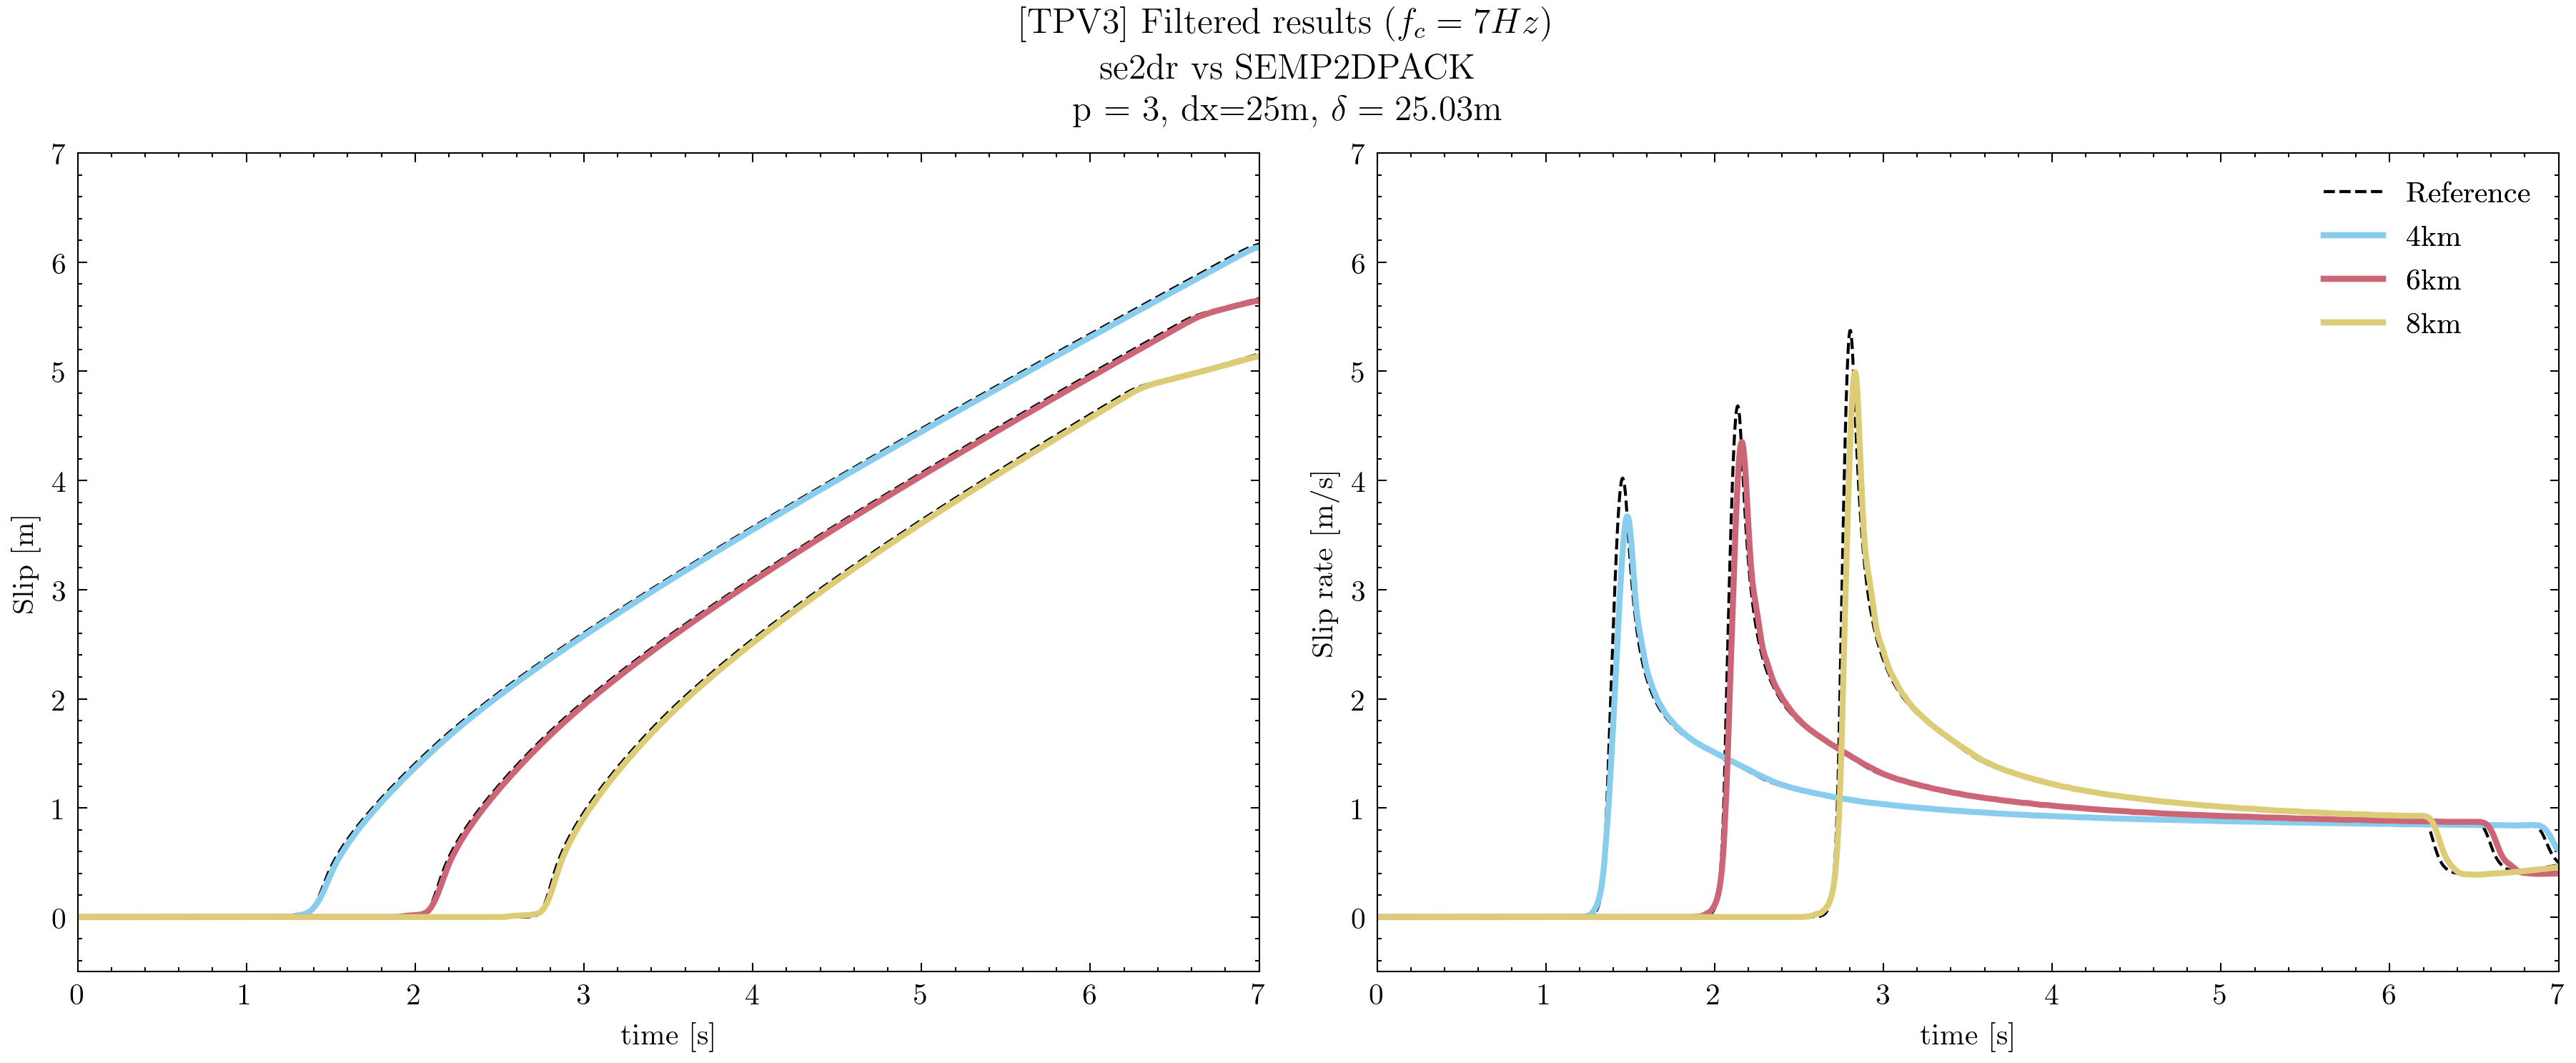

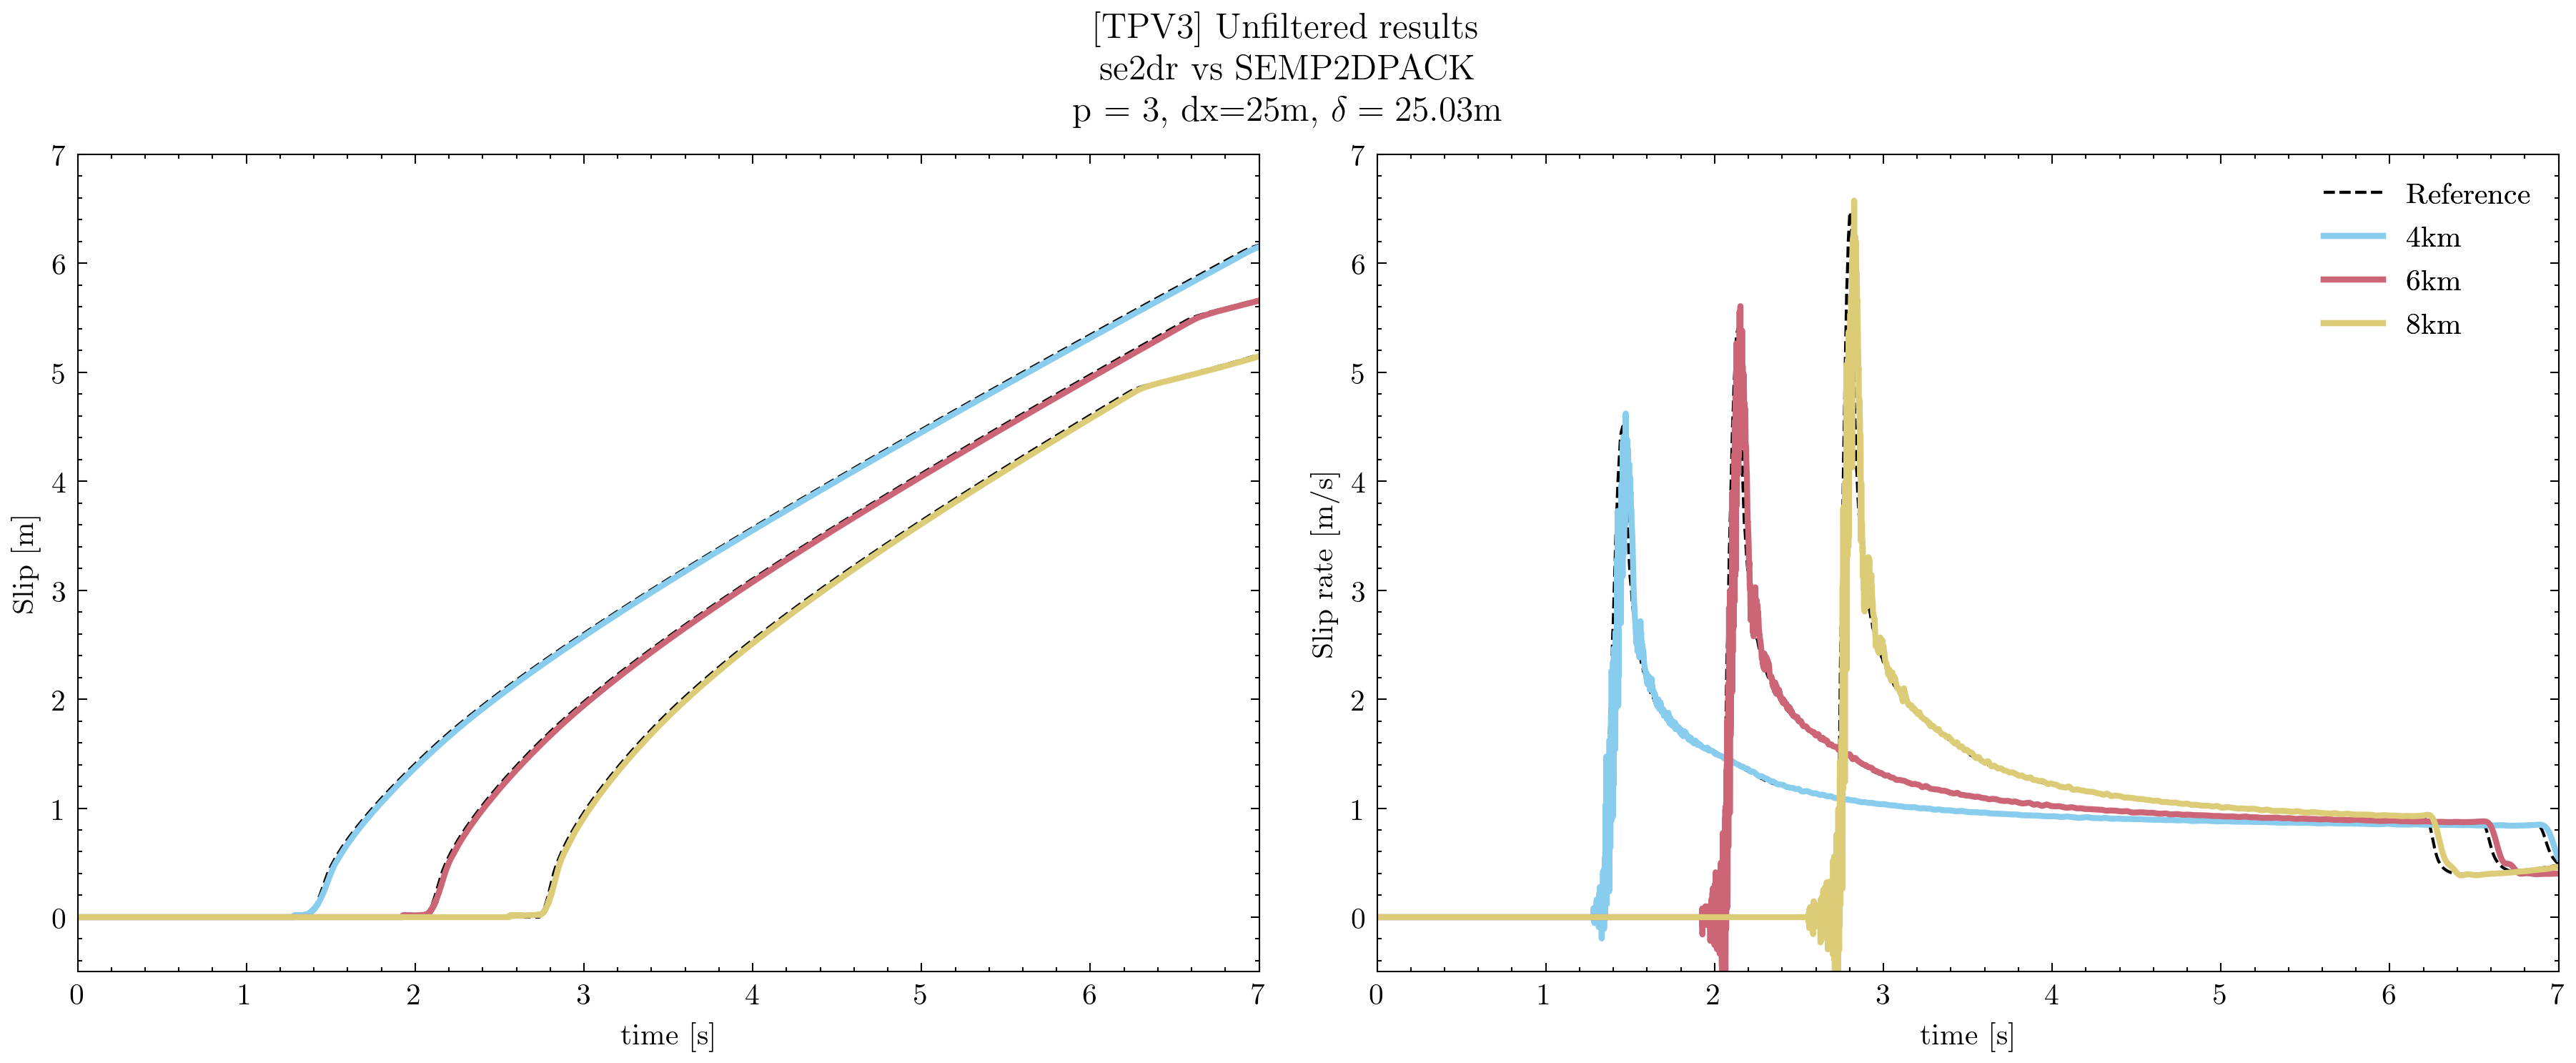

In [11]:
ReceiverFile = pd.read_csv(path+"20201012/TPV3/No6/receiverCP-dr-2400x2400-p3.dat", 
                           comment = '#',header = None, delimiter = " ")
ParamsText = "\nse2dr vs SEMP2DPACK\np = 3, dx=25m, $\delta=25.03$m" 

#FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE)

PlotReceiverCP_wPandas(ReceiverFile, ParamsText, RefList)

# todo: Plot the good plot
Plot independendently the slip rate figure for the best set of parameters

/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


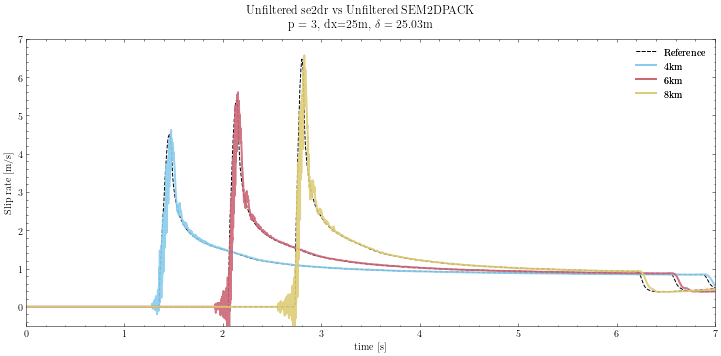

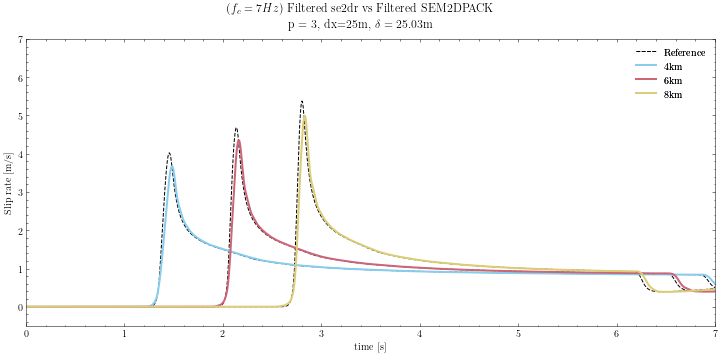

In [12]:
def GenericFigAxis2():
    fig = plt.figure(constrained_layout=True, figsize=[10,5])
    gs = GridSpec(1, 1, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    
    
    return fig, [ax1]

def PlotReceiverCP_wPandasUnfiltered(ReceiverFile, ParamsText, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}
    fig, axis = GenericFigAxis2()

    PlotType = "SlipRate"
    [item.PlotReference(axis[0], PlotType, filtering=False) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = False, **kwargs)

    format_axes(fig)
    fig.suptitle("Unfiltered se2dr vs Unfiltered SEM2DPACK{}".format(ParamsText))
    
def PlotReceiverCP_wPandasFiltered(ReceiverFile, ParamsText, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}
    fig, axis = GenericFigAxis2()

    PlotType = "SlipRate"
    [item.PlotReference(axis[0], PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

    format_axes(fig)
    if "CutoffFrequency" in kwargs:
        fig.suptitle("($f_c=${}$Hz$) Filtered se2dr vs Filtered SEM2DPACK{}".format(kwargs.get("CutoffFrequency"),ParamsText))
    else:
        fig.suptitle("($f_c=7Hz$) Filtered se2dr vs Filtered SEM2DPACK{}".format(ParamsText))
        
def PlotReceiverCP_wPandasAtAxis(ReceiverFile, ax, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}

    PlotType = "SlipRate"
    [item.PlotReference(ax, PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(ax, ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)


ReceiverFile = pd.read_csv(path+"20201012/TPV3/No6/receiverCP-dr-2400x2400-p3.dat", 
                           comment = '#',header = None, delimiter = " ")

ParamsText = "\np = 3, dx=25m, $\delta=25.03$m" 

PlotReceiverCP_wPandasUnfiltered(ReceiverFile, ParamsText, RefList,alpha=0.9)
PlotReceiverCP_wPandasFiltered(ReceiverFile, ParamsText, RefList)

In [13]:
path

'/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/[TPV3]Results/'

# Error analysis approach

In [14]:
def GetMaxPeakValueNTiming_FromLists(TimeList,MagnList):
        idx = MagnList.index(max(MagnList))
        
        PeakValue = MagnList[idx]
        PeakTiming = TimeList[idx]
        
        return [PeakTiming,PeakValue]
    
def GetDictDataReceiver(p, dx, ReceiverLoc, RefPair,ReceiverPair):
    ToAppendDict={"p": p,
                  "dx":  dx,
                  "ReceiverLoc": ReceiverLoc,
                  "TimingDifference": ReceiverPair[0]-RefPair[0], 
                  "SlipRateDifference":ReceiverPair[1]-RefPair[1]
                 }
    return ToAppendDict

def PlotnScatter3Lists(axis,x,y,z):
    axis.scatter(x, y)
    axis.plot(x, y,'o')
    for i, txt in enumerate(z):
        axis.annotate(txt, (x[i]+.005, y[i]+.005))

In [15]:
def GenericFigAxis():
    fig = plt.figure(constrained_layout=True, figsize=[12,4])
    gs = GridSpec(1, 3, figure=fig, wspace=0,hspace=0.)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    

    ax3.set_yticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xlabel("Timing Difference [s]")
    ax1.set_ylabel("Peak slip rate Difference [m/s]")
    
    ax1.xaxis.set_major_locator(MaxNLocator(5))
    ax1.yaxis.set_major_locator(MaxNLocator(5))
    
    ax2.xaxis.set_major_locator(MaxNLocator(5))
    ax2.yaxis.set_major_locator(MaxNLocator(5))
    
    ax3.xaxis.set_major_locator(MaxNLocator(5))
    ax3.yaxis.set_major_locator(MaxNLocator(5))
    
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    
    return fig, [ax1, ax2,ax3]


def GenericFigAxisExtra():
    fig = plt.figure(constrained_layout=True, figsize=[16,4])
    gs = GridSpec(1, 4, figure=fig, wspace=0,hspace=0.)
    
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[0, 2])
    ax3 = fig.add_subplot(gs[0, 3])
    

    ax3.set_yticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xlabel("Timing difference [s]")
    ax1.set_ylabel("Peak slip rate difference [m/s]")
    
    ax1.xaxis.set_major_locator(MaxNLocator(5))
    ax1.yaxis.set_major_locator(MaxNLocator(5))
    
    ax2.xaxis.set_major_locator(MaxNLocator(5))
    ax2.yaxis.set_major_locator(MaxNLocator(5))
    
    ax3.xaxis.set_major_locator(MaxNLocator(5))
    ax3.yaxis.set_major_locator(MaxNLocator(5))
    
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    
    return fig, ax0,[ax1, ax2,ax3]

# Extract only single p refinement window

In [16]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE)

The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 4km
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 4km


/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 6km
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 6km
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km
The TPV3reference object was generated from: SEM2DPACK and the receiver is located at 8km


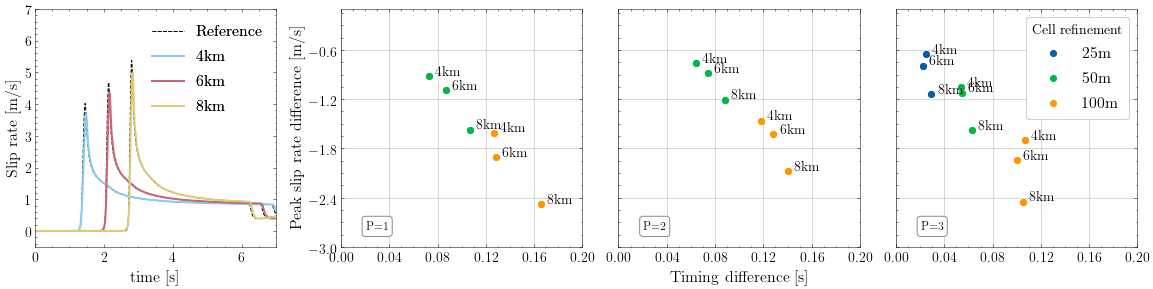

In [22]:
Data = pd.DataFrame(columns=["p","dx", "ReceiverLoc", "TimingDifference", "SlipRateDifference"])

CutoffFreq=10

for NumReceiver in range(3):
    
    # Get the reference Pair
    RefItem = RefList[NumReceiver]; print(RefItem)
    RefPair = GetMaxPeakValueNTiming_FromLists(RefItem.Time.tolist(),
                                               Butterworth(RefItem.SlipRate.tolist(),
                                                           CutoffFrequency = CutoffFreq)
                                              )
    
    # Get the reference Pair
    RefItem = RefList[NumReceiver]; print(RefItem)
    RefPair = GetMaxPeakValueNTiming_FromLists(RefItem.Time.tolist(),
                                               RefItem.SlipRate.tolist())
    
    # Get the receiver Pair No1 =====================================================
    ReceiverFile = pd.read_csv(path+"20201012/TPV3/No1/receiverCP-dr-600x600-p2.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )
    ToAppendDict = GetDictDataReceiver(2, "100m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    
    # Get the receiver Pair for No2 =====================================================
    ReceiverFile = pd.read_csv(path+"20201012/TPV3/No2/receiverCP-dr-600x600-p3.dat",
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )
    ToAppendDict = GetDictDataReceiver(3, "100m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    # Get the receiver Pair for No3 =====================================================
    ReceiverFile = pd.read_csv(path+"20201012/TPV3/No3/receiverCP-dr-1200x1200-p2.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )
    ToAppendDict = GetDictDataReceiver(2, "50m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    # Get the receiver Pair for No4 =====================================================
    ReceiverFile = pd.read_csv(path+"20201012/TPV3/No4/receiverCP-dr-1200x1200-p3.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )
    ToAppendDict = GetDictDataReceiver(3, "50m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    
    # Get the receiver Pair for No6 =====================================================
    ReceiverFile = pd.read_csv(path+"20201012/TPV3/No6/receiverCP-dr-2400x2400-p3.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )

    ToAppendDict = GetDictDataReceiver(3, "25m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    # Get the receiver Pair for No8 =====================================================
    ReceiverFile = pd.read_csv(path+"20201012/TPV3/No8/receiverCP-dr-600x600-p1.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )

    ToAppendDict = GetDictDataReceiver(1, "100m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    # Get the receiver Pair for No9 =====================================================
    ReceiverFile = pd.read_csv(path+"20201012/TPV3/No9/receiverCP-dr-1200x1200-p1.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )

    ToAppendDict = GetDictDataReceiver(1, "50m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    
    
    
p1Data = Data[Data.p == 1]
p2Data = Data[Data.p == 2]
p3Data = Data[Data.p == 3]

fig,ax0,axis=GenericFigAxisExtra()
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

for j,PNumData in enumerate([p1Data,p2Data,p3Data]):
    Loc1Data = PNumData[PNumData.dx == "25m"]
    Loc2Data = PNumData[PNumData.dx == "50m"]
    Loc3Data = PNumData[PNumData.dx == "100m"]

    for LocNumData in [Loc1Data,Loc2Data,Loc3Data]:
        PlotnScatter3Lists(axis[j], 
                           LocNumData.TimingDifference.tolist(),
                           LocNumData.SlipRateDifference.tolist(),
                           LocNumData.ReceiverLoc.tolist())
    
    # Lines Formatting axis 1
    Lines = axis[2].get_lines()
    legend2 = axis[2].legend(Lines, ['25m', '50m', '100m'],title='Cell refinement',frameon=True)
    axis[2].add_artist(legend2)
    
    axis[j].text(0.03, -2.75, 'P={}'.format(j+1), ha="center", va="center", size=12,
            bbox=bbox_props)


for ax in axis:
    ax.set_xlim(.0,.2)
    ax.set_ylim(-3,-.1)
    
ReceiverFile = pd.read_csv(path+"20201012/TPV3/No6/receiverCP-dr-2400x2400-p3.dat", 
                           comment = '#',header = None, delimiter = " ")
    
PlotReceiverCP_wPandasAtAxis(ReceiverFile, ax0, RefList)
ax0.set_xlim(0,7.0)
ax0.set_ylim(-0.5,7.0)
        
        
Lines = ax0.get_lines()[-4:]

legend2 = ax0.legend(Lines, ['Reference', '4km', '6km', '8km'], loc=1)
ax0.add_artist(legend2)
#fig.suptitle("Timing and peak slip rate difference wrt. SEM2DPACK reference \n  low-pass Butterworth filter ($f_c=${}$Hz$)".format(CutoffFreq))